In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
#exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
#mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])



Bad key "text.kerning_factor" on line 4 in
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/data/disk01/home/jasonfan/threeML/threeML/__init__.py:12: UserWarning: No DISPLAY variable set. Using backend for graphics without display (Agg)
  warnings.warn("No DISPLAY variable set. Using backend for graphics without display (Agg)")
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of K to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/paramet

In [2]:
from imp import reload
reload(IceCubeLike)

import warnings
warnings.filterwarnings("ignore")
#data = np.random.choice(exp, 10000).copy()
#jl._data_list['test'].llh_model.update_data(data)
IceCube=IceCubeLike.IceCubeLike("test",exp,mc,exp,verbose=True,background_time_profile= (56224,56324),sampling_width=np.radians(1))
del mc

In [3]:
source1_sp = Powerlaw()
#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1_sp.K=1e-13
source1_neutrino = Powerlaw()
source1_neutrino._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1_neutrino.piv=1000
source1_neutrino.K=1e-13
source1_neutrino.index=-2
#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1 = PointSource("source1", ra=83.63, dec=22.0145, spectral_shape=source1_sp)
source1_nu = IceCubeLike.NeutrinoPointSource("source1_nu",ra=83.63, dec=22.0145,spectral_shape=source1_neutrino,energy_unit=u.GeV)

model = Model(source1,source1_nu)
model.source1.spectrum.main.Powerlaw.K.fix = True
model.source1.spectrum.main.Powerlaw.index.fix = True
model.source1_nu.spectrum.main.Powerlaw.K.bounds = (1e-30, 1e-5)
model.source1_nu.spectrum.main.Powerlaw.index.bounds = (-4, -1)
#model.source1_nu.spectrum.main.Powerlaw.index.fix = True
#IceCube.set_model(model)
IceCubedata = DataList(IceCube)
jl = JointLikelihood(model, IceCubedata)

In [4]:
test=IceCubeLike.sensitivity(jl)

In [5]:
test.set_backround(grl,model ,time_window=100,start_time=56224)

In [6]:
import mla 
basespectrum = mla.spectral.PowerLaw(1e3 , 1 , -2)
test.set_injection(background_time_profile = (56224,56324))

In [7]:
import numpy.lib.recfunctions as rf
basespectrum = mla.spectral.PowerLaw(1e3 , 1 , -2)
basespectrum.A=1e-13
test.PS_injector.update_spectrum(basespectrum)
#test.jl_value.llh_model.update_spectrum(basespectrum)
testdata=test.draw_data()
sample=test.draw_signal()
sample = rf.drop_fields(sample, [n for n in sample.dtype.names \
                       if not n in testdata.dtype.names])
testdata=np.concatenate([testdata,sample])
#test.jl_value.llh_model.update_data(test.draw_data())
#test.jl_value.llh_model.modify_injection(test.draw_signal())
#np.save("test3.npy",testdata)
#testdata=np.load("test.npy")
test.jl_value.llh_model.update_data(testdata)

In [8]:
(test.jl_value.llh_model.data["run"]>1000000).sum()

47

In [9]:
test.jl_value.verbose=True
test.jl.fit()

(46.29658933395464, 248.17277084597316)
(46.59940991914495, 248.14663106356866)
(45.99570849468812, 248.19569462081563)
(46.35458531102214, 248.16800176788027)
(46.23866487643297, 248.17742134810652)
(46.36799696715244, 248.15281626509648)
(46.22532087822473, 248.1924602496137)
(46.34432415262599, 248.15945663877548)
(46.24891674974303, 248.18596647678214)
(39.32756844154653, 248.62923052347048)
(41.363639312417796, 248.7339769650722)
(41.415539818931826, 248.73981245557647)
(41.31180291633035, 248.72803751889415)
(41.40542587692707, 248.73179294074524)
(41.32190685620601, 248.73605954878985)
(41.7823566125618, 248.99712333850437)
(43.631329382395485, 249.77017700453527)
(46.326701983068155, 250.06861072013453)
(46.38862705835389, 250.06667125596317)
(46.264858326333915, 250.0704160906317)
(46.37250296652419, 250.06713617333986)
(46.280962980661116, 250.0699742653813)
(45.436975307135086, 250.0816453691434)
(45.49432863351326, 250.08158316355826)
(45.3796931976579, 250.08159069064385)


,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.46 -0.31 +0.4) x 10^-19,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.12 +/- 0.06,



Correlation matrix:



1.00,-0.88
-0.88,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-250.081887
total,-250.081887



Values of statistical measures:



,statistical measures
AIC,-502.163775
BIC,-500.163775


(                                                value  negative_error  \
 source1_nu.spectrum.main.Powerlaw.K      1.456430e-19    1.146497e-13   
 source1_nu.spectrum.main.Powerlaw.index -2.119914e+00   -6.643717e-02   
 
                                          positive_error         error  \
 source1_nu.spectrum.main.Powerlaw.K        1.853687e-13  1.500092e-13   
 source1_nu.spectrum.main.Powerlaw.index    6.252678e-02  6.448197e-02   
 
                                                     unit  
 source1_nu.spectrum.main.Powerlaw.K      1 / (cm2 keV s)  
 source1_nu.spectrum.main.Powerlaw.index                   ,
        -log(likelihood)
 test        -250.081887
 total       -250.081887)

In [10]:
K=np.linspace(5e-14,1e-12,50)
gamma=np.linspace(-1,-4,30)
ns=np.linspace(0,60,50)
result=[]
for j in gamma:
    source1_neutrino = Powerlaw()
    source1_neutrino._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
    source1_neutrino.piv=1000
    source1_neutrino.index=j
    source1_nu = IceCubeLike.NeutrinoPointSource("source1_nu",ra=83.63, dec=22.0145,spectral_shape=source1_neutrino)
    model = Model(source1_nu)
    test.jl_value.set_model(model)
    test.jl_value.update_model()
    for i in K:
        source1_neutrino.K=i
        ns = (test.jl_value.llh_model.sim['ow'] * source1_neutrino(test.jl_value.llh_model.sim['trueE']) * test.jl_value.llh_model.signal_time_profile.effective_exposure() *24*3600).sum() 
        temp=test.jl_value.llh_model.eval_llh_ns(ns)
        result.append([i,j,temp[0],temp[1]])

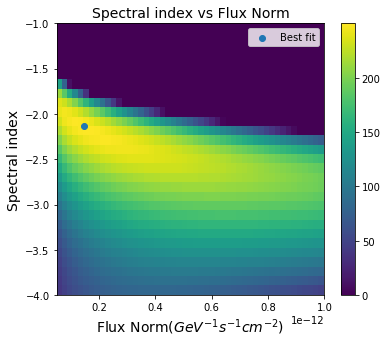

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
result=np.array(result)
x=result[:,0]
y=result[:,1]
z=result[:,3]

## Equivalently, we could do that all in one line with:
# x,y,z = np.genfromtxt('eye_.txt', delimiter=',', usecols=(0,1,2))
z[z<0]=0
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z=z.reshape(len(y),len(x))
index=result[np.argmax(result[:,3])]
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(X,np.flip(Y),Z)
plt.colorbar()
plt.scatter(index[0],index[1],label="Best fit")
plt.title("Spectral index vs Flux Norm",fontsize=14)
plt.xlabel(r"Flux Norm($GeV^{-1} s^{-1} cm^{-2}$)",fontsize=14)
#plt.xlabel(r"ns",fontsize=14)
plt.ylabel("Spectral index",fontsize=14)
plt.legend()
plt.show()

In [12]:
K=np.linspace(5e-14,1e-12,50)
gamma=np.linspace(-1,-4,30)
ns=np.linspace(0,70,100)
result=[]
for j in gamma:
    source1_neutrino = Powerlaw()
    source1_neutrino._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
    source1_neutrino.piv=1000
    source1_neutrino.index=j
    source1_nu = IceCubeLike.NeutrinoPointSource("source1_nu",ra=83.63, dec=22.0145,spectral_shape=source1_neutrino)
    model = Model(source1_nu)
    test.jl_value.set_model(model)
    test.jl_value.update_model()
    for i in ns:
        
        n_s = i 
        temp=test.jl_value.llh_model.eval_llh_ns(n_s)
        result.append([i,j,temp[0],temp[1]])

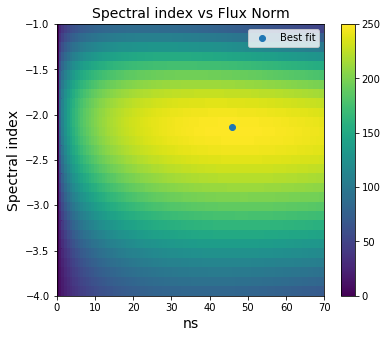

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
result=np.array(result)
x=result[:,0]
y=result[:,1]
z=result[:,3]

## Equivalently, we could do that all in one line with:
# x,y,z = np.genfromtxt('eye_.txt', delimiter=',', usecols=(0,1,2))
z[z<0]=0
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z=z.reshape(len(y),len(x))
index=result[np.argmax(result[:,3])]
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(X,np.flip(Y),Z)
plt.colorbar()
plt.scatter(index[0],index[1],label="Best fit")
plt.title("Spectral index vs Flux Norm",fontsize=14)
plt.xlabel(r"ns",fontsize=14)
#plt.xlabel(r"ns",fontsize=14)
plt.ylabel("Spectral index",fontsize=14)
plt.legend()
plt.show()

In [23]:
from imp import reload
import scipy.optimize
reload(mla.core)

sim = read(glob.glob(sim_files))
import warnings
warnings.filterwarnings("ignore")
testmla=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , testdata , sim, "PowerLaw", background = exp , \
                              background_time_profile = (56224,56324))

In [27]:
#testmla.update_energy_weight()
testmla.get_fit_result()

AttributeError: 'LLH_point_source' object has no attribute 'fit_ns'

In [15]:
gamma=np.linspace(-1.5,-3.5,30)
ns=np.linspace(0,70,60)
result=[]
tempresult=np.zeros((60,30))
for i,ga in enumerate(gamma):
    testmla.update_energy_weight(gamma=ga)
    for j,nss in enumerate(ns):
        temp=testmla.eval_llh_ns(nss)
        result.append([ga,nss,temp[0],temp[1]])
        tempresult[j][i]=temp[1]

(44.51547039206721, 263.02490721370685)

In [17]:
#ns=testmla.get_fit_result()[1]
sob_ratios = testmla.evaluate_interpolated_ratio()
sob_spline = np.zeros(len(testmla.data), dtype=object)
for i in range(len(testmla.data)):
    spline = scipy.interpolate.UnivariateSpline(testmla.gamma_point,
                            np.log(sob_ratios[i]),
                            k = 3,
                            s = 0,
                            ext = 'raise')
    sob_spline[i] = spline

In [18]:
def inner_ts(params):
    gamma=params[0]
    ns=params[1]
    e_lh_ratio = testmla.get_energy_sob(gamma, sob_spline)
    ts = ( ns/testmla.N * (e_lh_ratio*testmla.spatial*testmla.t_lh_ratio - 1))+1
    return -2*(np.sum(np.log(ts))+testmla.drop*np.log(1-ns/testmla.N))

bounds= [[testmla.gamma_point[0], testmla.gamma_point[-1]],[0,testmla.N]]
bf_params = scipy.optimize.minimize(inner_ts,
                    x0 = [-2,1],
                    bounds = bounds,
                    method = 'SLSQP',
                    )

In [19]:
bf_params

     fun: -268.8251510579472
     jac: array([-0.00087738, -0.00015259])
 message: 'Optimization terminated successfully.'
    nfev: 46
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([-2.13622469, 47.364395  ])

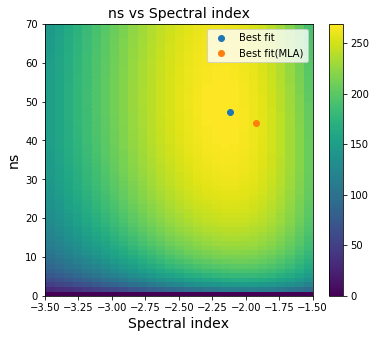

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
result=np.array(result)
x=result[:,0]
y=result[:,1]
z=result[:,3]
gamma=np.linspace(-1.5,-3.5,30)
ns=np.linspace(0,70,60)
## Equivalently, we could do that all in one line with:
# x,y,z = np.genfromtxt('eye_.txt', delimiter=',', usecols=(0,1,2))
z[z<0]=0
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z=z.reshape(len(y),len(x))
#index=result[np.argmax(result[:,3])]
index=np.unravel_index(tempresult.argmax(), tempresult.shape)
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(np.flip(X),Y,tempresult)
plt.colorbar()
plt.scatter(gamma[index[1]],ns[index[0]],label="Best fit")
plt.scatter(testmla.get_fit_result()[0],testmla.get_fit_result()[1],label="Best fit(MLA)")
plt.title("ns vs Spectral index",fontsize=14)
plt.xlabel(r"Spectral index",fontsize=14)
plt.ylabel("ns",fontsize=14)
plt.legend()
plt.show()

In [21]:
gamma=np.linspace(-1.5,-3.5,30)
ns=np.linspace(0,70,60)
print(gamma[index[1]],ns[index[0]])

-2.1206896551724137 47.45762711864407
